# Implementing Thompson Sampling For MovieLens 100k Datasaet


### Initialization python envirnment


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
rng = np.random.default_rng()



### Loading the data and define train and test data

In [5]:
item_file = 'ml-100k/u.item'
user_file = 'ml-100k/u.user'
rating_file = 'ml-100k/u.data'


item_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
] + [f'genre_{i}' for i in range(19)]  # 19 genres

rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

items = pd.read_csv(item_file, sep='|', encoding='latin-1', names=item_cols, header=None)
users = pd.read_csv(user_file, sep='|', names=user_cols, header=None)

ratings = pd.read_csv(rating_file, sep='\t', names=rating_cols, header=None)

#  sorting ratings by timestamp before splitting to simulate chronological learning:
ratings = ratings.sort_values(by='timestamp')

X = ratings.drop('rating', axis=1)
y = ratings['rating']

ix = int(len(ratings) * 0.8)
train = ratings.iloc[0:ix,:]
test = ratings.iloc[ix:,:]

### Define Arms to be Movie Ids

In [6]:
unique_arms = ratings['movie_id'].unique()


# Thompson Sampling

In Thompson sampling, we assume there are K arms, each with reward 1 with probaiblity $\theta_k$, and reward 0 with probability of $1-\theta_k$. This is Bernoulli distribution and $\theta_k$ can be mean reward.

The prior distribution for Bernoulli distribution is be $Beta(\alpha, \beta)$, and based on conjugate prior properties, the posterior will be _Beta_ distribution and it will be updated by:

$$
    (\alpha_k, \beta_k)= 
\begin{cases}
    (\alpha_k, \beta_k),& \text{if } x_k \neq k\\
    (\alpha_k, \beta_k) + (r_t, 1-r_t),& \text{else } 
\end{cases}
$$

$r_t$ could be 0 or 1. if it's 1, then $\alpha_k$ will be added by 1 and if it's 0, $\beta_k$ will be added by 1.

In [7]:
# Thompson Sampling class
class ThompsonSampling:
    def __init__(self, arms):
        self.arms = arms  # list of movie_ids
        # standard uninformative priors for Beta(1, 1)
        self.alpha = {arm: 1.0 for arm in arms}  # prior: 1 success
        self.beta = {arm: 1.0 for arm in arms} # prior: 1 failure

    def select_arm(self):
        samples = {}
        
        for arm in self.arms:
            alpha = self.alpha[arm]
            beta = self.beta[arm]
            samples[arm] = rng.beta(alpha, beta) # sample from posterior distribution
        
        return max(samples, key=samples.get)


    def update(self, chosen_arm, reward):
        if reward == 1:
            self.alpha[chosen_arm] += 1
        else:
            self.beta[chosen_arm] += 1
            
    def get_posterior_mean(self):
        mean = {}
        for arm in self.arms:
            mean[arm] = self.alpha[arm]/(self.alpha[arm] + self.beta[arm])
        return mean       

### Online Training
We simulate online interactions

In [8]:

ts = ThompsonSampling(unique_arms)


total_interactions = 0
total_rewards = 0

num_interactions_per_user = 3  # <--- you can change this number

unique_users = train['user_id'].unique()

for user_id in unique_users:
    for _ in range(num_interactions_per_user):
        chosen_movie = ts.select_arm()
        # Check if this user rated the chosen movie
        row = train[(train['user_id'] == user_id) & (train['movie_id'] == chosen_movie)]
        
        
        reward = 0
        if len(row) > 0:
            #If a user rated the same movie multiple times (which is rare but possible in some systems),
            #you might want to take the most recent rating (or average).
            rating = row.sort_values(by='timestamp', ascending=False).iloc[0]['rating']

            #OR
            #rating = row.iloc[0]['rating']
            
            reward = int(rating >= 4)
            
            
        ts.update(chosen_movie, reward)
        total_rewards += reward
        total_interactions += 1
    
print(f"Total Interactions: {total_interactions}")
print(f"Total Reward (ratings ≥ 4): {total_rewards}")
print(f"Average Reward: {total_rewards / total_interactions:.4f}")

Total Interactions: 2253
Total Reward (ratings ≥ 4): 97
Average Reward: 0.0431


# Evaluation
Compute precision@k

In [9]:
def is_recommended(row):
    if (row['rating']>=4):
        return 1
    else:
        return 0


k = 5
precision_k = 0
unique_users = test['user_id'].unique()
user_count = len(unique_users)

mean = ts.get_posterior_mean()

value_sorted = sorted(mean.items(), key = lambda x:x[1], reverse = True)

#If we decide to use only top k movies
selected_movies = [item[0] for item in value_sorted[:k]]



for user in unique_users:
    
    filtered_test = test.loc[(test['user_id'] == user) & (test['movie_id'].isin(selected_movies))].copy()
    if len(filtered_test)>0:
        filtered_test['result'] = filtered_test.apply(is_recommended, axis = 1)
        count = filtered_test['result'].sum()
        precision_k += (count/k)
precision_k = precision_k/user_count
print(precision_k)
    
    

0.18073089700996686


### Average cumulative rewards with simulation


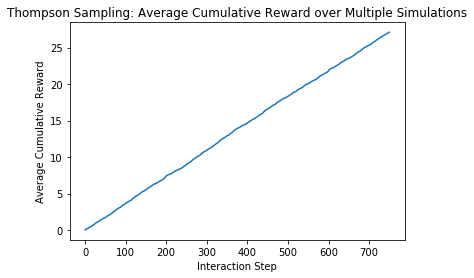

In [10]:

num_simulations = 100

    
all_runs = [] # stores cumulative rewards from each simulation

for sim in range(num_simulations):

    ts = ThompsonSampling(unique_arms)

    total_interactions = 0
    total_rewards = 0

    num_interactions_per_user = 1  # <--- you can change this number

    # To ensure diverse simulations, shuffle users in each run
    unique_users = np.random.permutation(train['user_id'].unique())

    cum_reward =[]
    cur_step = 0

    for user_id in unique_users:
        for _ in range(num_interactions_per_user):
            chosen_movie = ts.select_arm()
            # Check if this user rated the chosen movie
            row = train[(train['user_id'] == user_id) & (train['movie_id'] == chosen_movie)]

            reward = 0 ## DEFAULT: Assume 0 reward if the user didn't rate the chosen movie
            if len(row) > 0:
                rating = row.iloc[0]['rating']
                reward = int(rating >= 4)

            ts.update(chosen_movie, reward)
            total_rewards += reward
            total_interactions += 1

            cum_reward.append(total_rewards)

    all_runs.append(cum_reward)


ave_cum_reward = np.mean(all_runs, axis=0)        
plt.plot(ave_cum_reward)

plt.title('Thompson Sampling: Average Cumulative Reward over Multiple Simulations')
plt.xlabel('Interaction Step')
plt.ylabel('Average Cumulative Reward')
plt.show()
